#### This notebook describes:

#### 1) How the neigborhood interactions between Niches in IPF and healthy tissue were calculated for figure 2f,g

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
import os
import sys
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import colors

#import scvi
import anndata as ad

import warnings
warnings.filterwarnings("ignore")

from collections import Counter

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

plt.rcParams['figure.figsize'] = (6, 6)

from IPython.core.display import display, HTML
import random

#Define a colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
#colorsComb = np.vstack([colors3, colors2])
#mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
from matplotlib import colors
colorsComb = np.vstack([plt.cm.Reds(np.linspace(0, 1, 128)), plt.cm.Greys_r(np.linspace(0.7, 0.8, 0))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# Helper function to split list in chunks
def chunks(lista, n):
    for i in range(0, len(lista), n):
        yield lista[i:i + n]
        
        plt.rcParams['figure.figsize'] = (6, 5)
sc.set_figure_params(dpi=100, vector_friendly=True)
def mysize(w, h, d):
    fig, ax = plt.subplots(figsize = (w, h), dpi = d)
    return(fig.gca())
plt.rcParams['figure.figsize'] = (6, 5)
sc.set_figure_params(dpi=100, vector_friendly=True)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import scvi

Global seed set to 0


In [3]:
## frequently used variables
from matplotlib import colors
import matplotlib.pyplot as plt
colorsComb = np.vstack([plt.cm.Reds(np.linspace(0, 1, 128)), plt.cm.Greys_r(np.linspace(0.7, 0.8, 0))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## Along these Lines, a colourmap diverging from gray to red
gray_red = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "red", "darkred"], N = 128)

## Some more Colour Maps
gray_violet = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "mediumvioletred", "indigo"], N = 128)
gray_blue = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "cornflowerblue", "darkblue"], N = 128)


def mysize(w, h, d):
    fig, ax = plt.subplots(figsize = (w, h), dpi = d)
    return(fig.gca())
#plt.rcParams['figure.figsize'] = (6, 5)
#sc.set_figure_params(dpi=120, vector_friendly=True)

In [4]:
import matplotlib.colors as colors
c_low = colors.colorConverter.to_rgba('orange', alpha = 0)
c_high = colors.colorConverter.to_rgba('red',alpha = 1)
cmap_transparent = colors.LinearSegmentedColormap.from_list('rb_cmap',[c_low, c_high], 512)

In [5]:
import matplotlib.colors as colors
c_low2 = colors.colorConverter.to_rgba('green', alpha = 0)
c_high2 = colors.colorConverter.to_rgba('darkblue',alpha = 1)
cmap_transparent2 = colors.LinearSegmentedColormap.from_list('rb_cmap',[c_low2, c_high2], 512)

In [7]:
print(f"squidpy=={sq.__version__}")
print(f"scanpy=={sc.__version__}")

squidpy==1.2.3
scanpy==1.9.3


In [11]:
import cell2location as c2l
from cell2location.utils import select_slide

# load data

In [12]:
##load
adata_vis = sc.read(f".h5ad")

In [13]:
adata_vis

AnnData object with n_obs × n_vars = 57787 × 12486
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'n_genes', 'leiden', 'leiden_15', 'leiden_2', 'leiden_25', 'sampleID', 'treatment', 'VisiumSlides', 'technology', '_indices', '_scvi_batch', '_scvi_labels', 'AT0', 'AT1', 'AT2', 'Aberrant basaloid', 'Adventitial fibroblast', 'Alveolar fibroblast', 'Artery', 'B/Plasma', 'Basal', 'Basophil/Mast', 'Bronchial Vessel', 'Capillary', 'Capillary Aerocyte', 'Ciliated', 'Ciliated SFTPB+/SCGB1A1+', 'Dendritic', 'Ionocyte', 'Lymphatic', 'Macrophage C1Q hi', 'Macrophage CHI3L1+/CD9 hi/', 'Macrophage FABP4+', 'Macrophage IL1B+', 'Macrophage LYVE1+', 'Macrophage RETN+/VCAN+', 'Mesothelial', 'Monocyte', 'Mucous', 'Myofibroblast', 'NK', 'Peribronchial fibroblast', 'Pericyte', 'S

In [14]:
Niche_NMF_palette = dict(zip(adata_vis.obs.Niche_NMF.cat.categories, adata_vis.uns["Niche_NMF_colors"]))

In [15]:
cts = ['AT0', 'AT1', 'AT2', 'Aberrant basaloid', 'Adventitial fibroblast', 'Alveolar fibroblast',
       'Artery', 'B/Plasma', 'Basal', 'Basophil/Mast', 'Bronchial Vessel', 'Capillary', 'Capillary Aerocyte',
       'Ciliated', 'Ciliated SFTPB+/SCGB1A1+', 'Dendritic', 'Ionocyte', 'Lymphatic', 'Macrophage C1Q hi',
       'Macrophage CHI3L1+/CD9 hi/', 'Macrophage FABP4+', 'Macrophage IL1B+', 'Macrophage LYVE1+', 
       'Macrophage RETN+/VCAN+', 'Mesothelial', 'Monocyte', 'Mucous', 'Myofibroblast', 'NK', 
       'Peribronchial fibroblast', 'Pericyte', 'Smooth Muscle', 'T cell', 'TB-SC', 'Vein', 'pDC', 'preTB-SC/RAS']

# try neighborhood enrichment from squidpy

## subset to IPF only

In [18]:
IPF = adata_vis[adata_vis.obs["treatment"].isin(["IPF"])]

In [19]:
IPF

View of AnnData object with n_obs × n_vars = 30843 × 12486
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'n_genes', 'leiden', 'leiden_15', 'leiden_2', 'leiden_25', 'sampleID', 'treatment', 'VisiumSlides', 'technology', '_indices', '_scvi_batch', '_scvi_labels', 'AT0', 'AT1', 'AT2', 'Aberrant basaloid', 'Adventitial fibroblast', 'Alveolar fibroblast', 'Artery', 'B/Plasma', 'Basal', 'Basophil/Mast', 'Bronchial Vessel', 'Capillary', 'Capillary Aerocyte', 'Ciliated', 'Ciliated SFTPB+/SCGB1A1+', 'Dendritic', 'Ionocyte', 'Lymphatic', 'Macrophage C1Q hi', 'Macrophage CHI3L1+/CD9 hi/', 'Macrophage FABP4+', 'Macrophage IL1B+', 'Macrophage LYVE1+', 'Macrophage RETN+/VCAN+', 'Mesothelial', 'Monocyte', 'Mucous', 'Myofibroblast', 'NK', 'Peribronchial fibroblast', 'Peric

In [20]:
IPF = IPF[-IPF.obs["Niche_NMF"].isin(["no tissue"])]

## subset healthy only

In [26]:
healthy = adata_vis[adata_vis.obs["treatment"].isin(["Healthy"])]

In [27]:
healthy

View of AnnData object with n_obs × n_vars = 26944 × 12486
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'n_genes', 'leiden', 'leiden_15', 'leiden_2', 'leiden_25', 'sampleID', 'treatment', 'VisiumSlides', 'technology', '_indices', '_scvi_batch', '_scvi_labels', 'AT0', 'AT1', 'AT2', 'Aberrant basaloid', 'Adventitial fibroblast', 'Alveolar fibroblast', 'Artery', 'B/Plasma', 'Basal', 'Basophil/Mast', 'Bronchial Vessel', 'Capillary', 'Capillary Aerocyte', 'Ciliated', 'Ciliated SFTPB+/SCGB1A1+', 'Dendritic', 'Ionocyte', 'Lymphatic', 'Macrophage C1Q hi', 'Macrophage CHI3L1+/CD9 hi/', 'Macrophage FABP4+', 'Macrophage IL1B+', 'Macrophage LYVE1+', 'Macrophage RETN+/VCAN+', 'Mesothelial', 'Monocyte', 'Mucous', 'Myofibroblast', 'NK', 'Peribronchial fibroblast', 'Peric

In [28]:
healthy = healthy[-healthy.obs["Niche_NMF"].isin(["no tissue"])]

# now for whole IPF and whole healthy

In [31]:
sq.gr.spatial_neighbors(IPF, spatial_key="spatial", library_key="sampleID",transform=None, n_rings=1)
sq.gr.nhood_enrichment(IPF, cluster_key="Niche_NMF",)

  0%|          | 0/1000 [00:00<?, ?/s]

In [32]:
#adata_vis.uns["leiden_nhood_enrichment"]["zscore"] = np.nan_to_num(adata_vis.uns["leiden_nhood_enrichment"]["zscore"], copy=True, nan=0.0, posinf=None, neginf=None)

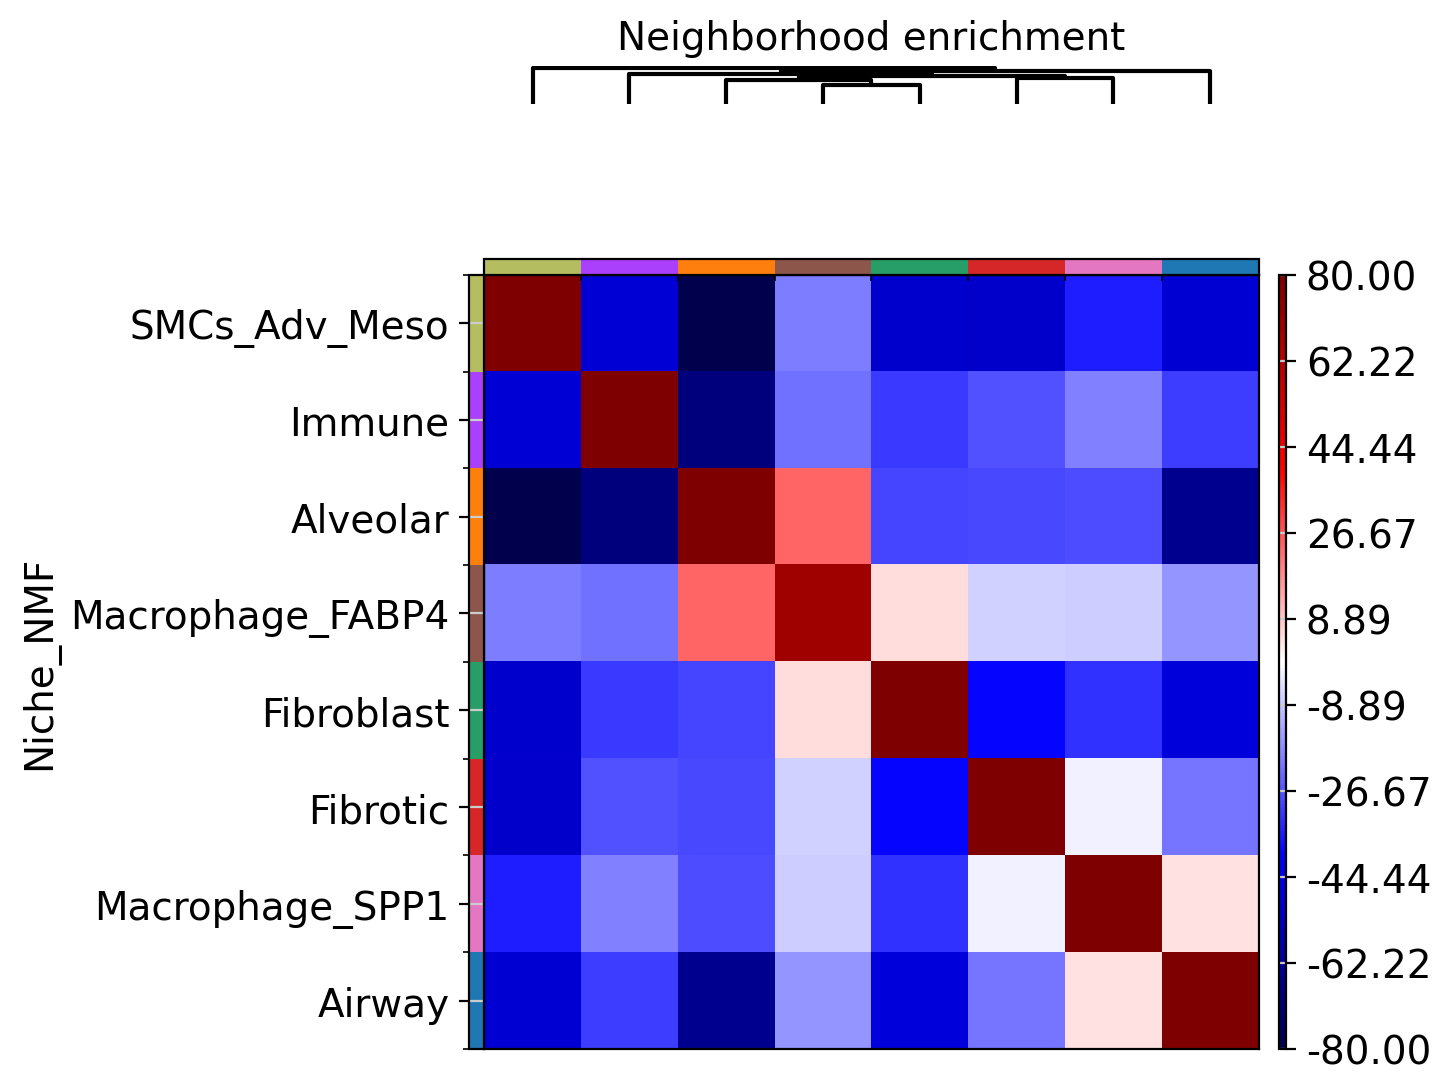

In [33]:
sq.pl.nhood_enrichment(IPF, cluster_key="Niche_NMF", method="average", cmap="seismic",vmin=-80, vmax=80, vcenter=0, figsize=(5,5),)# mode="zscore")

In [111]:
niche_IPF = pd.DataFrame(IPF.uns["Niche_NMF_nhood_enrichment"]["count"], index=IPF.obs['Niche_NMF'].cat.categories, columns = IPF.obs['Niche_NMF'].cat.categories)
niche_IPF

,Airway,Alveolar,Fibroblast,Fibrotic,Immune,Macrophage_FABP4,Macrophage_SPP1,SMCs_Adv_Meso
Airway,12136,422,626,787,1305,18,582,808
Alveolar,422,28246,5139,2317,2264,1231,384,1833
Fibroblast,626,5139,17498,1057,3097,626,67,2852
Fibrotic,787,2317,1057,9352,1470,163,441,724
Immune,1305,2264,3097,1470,18336,56,318,2866
Macrophage_FABP4,18,1231,626,163,56,758,15,151
Macrophage_SPP1,582,384,67,441,318,15,3390,77
SMCs_Adv_Meso,808,1833,2852,724,2866,151,77,26944


In [112]:
sns.reset_defaults()

<Axes: >

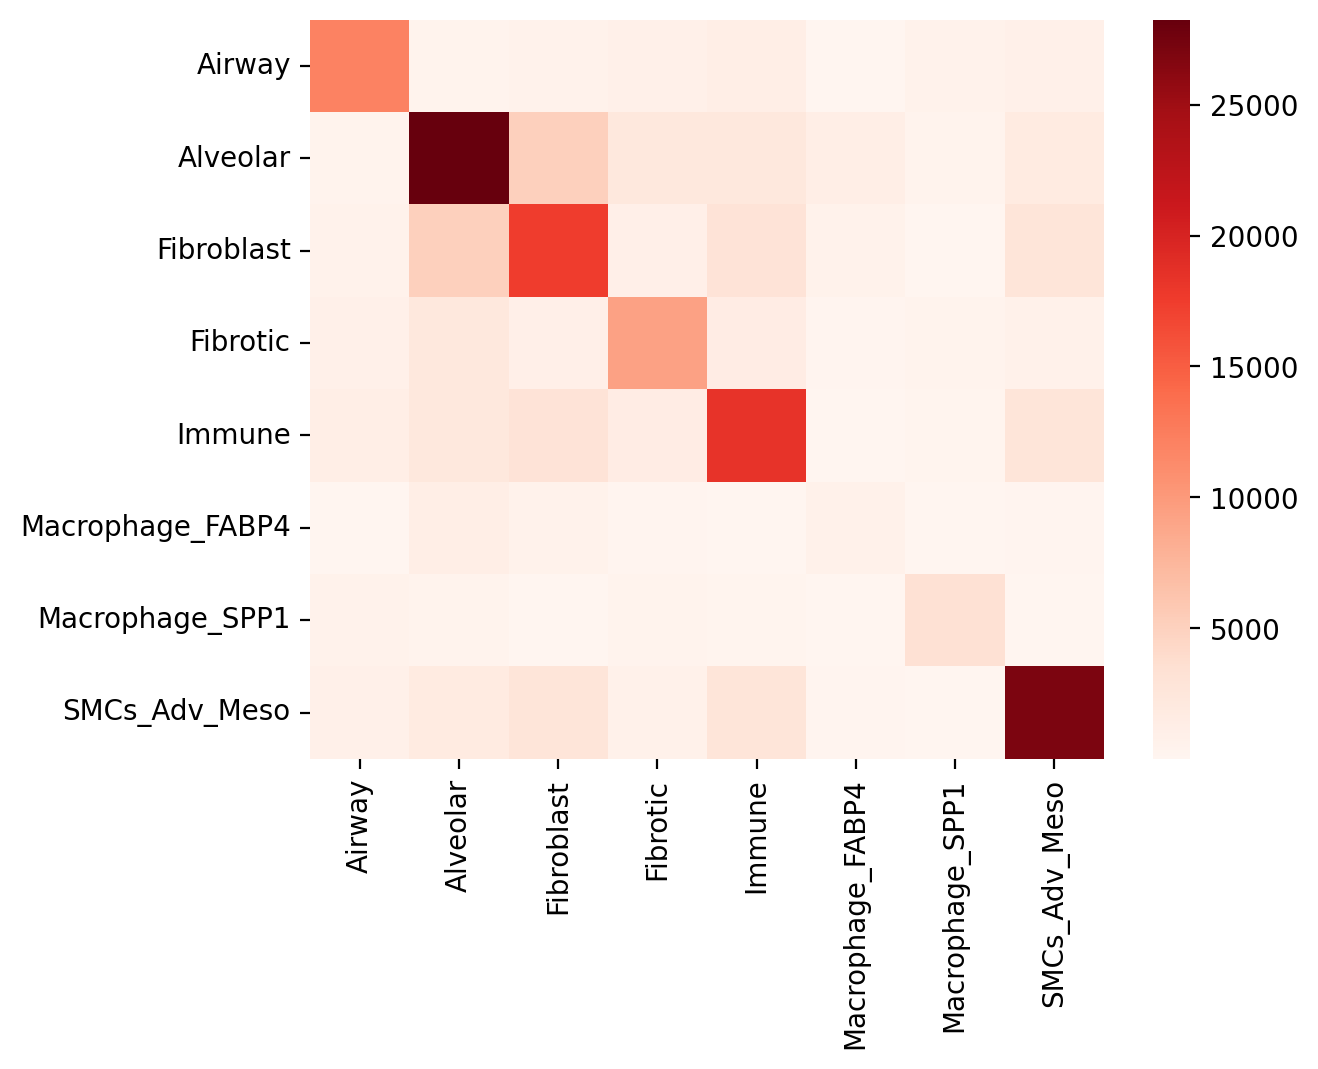

In [113]:
sns.heatmap(niche_IPF, annot=False, cmap=mymap, )

In [134]:
tab_IPF = niche_IPF.div(niche_IPF.sum(axis=1), axis=0)
tab_IPF

,Airway,Alveolar,Fibroblast,Fibrotic,Immune,Macrophage_FABP4,Macrophage_SPP1,SMCs_Adv_Meso
Airway,0.727404,0.025294,0.037521,0.047171,0.078219,0.001079,0.034884,0.048430
Alveolar,0.010087,0.675160,0.122837,0.055383,0.054116,0.029424,0.009179,0.043814
Fibroblast,0.020218,0.165978,0.565144,0.034139,0.100026,0.020218,0.002164,0.092113
Fibrotic,0.048250,0.142051,0.064803,0.573355,0.090123,0.009993,0.027037,0.044387
Immune,0.043922,0.076198,0.104234,0.049475,0.617124,0.001885,0.010703,0.096459
Macrophage_FABP4,0.005964,0.407886,0.207422,0.054009,0.018555,0.251160,0.004970,0.050033
Macrophage_SPP1,0.110353,0.072810,0.012704,0.083618,0.060296,0.002844,0.642776,0.014600
SMCs_Adv_Meso,0.022287,0.050559,0.078665,0.019970,0.079051,0.004165,0.002124,0.743180


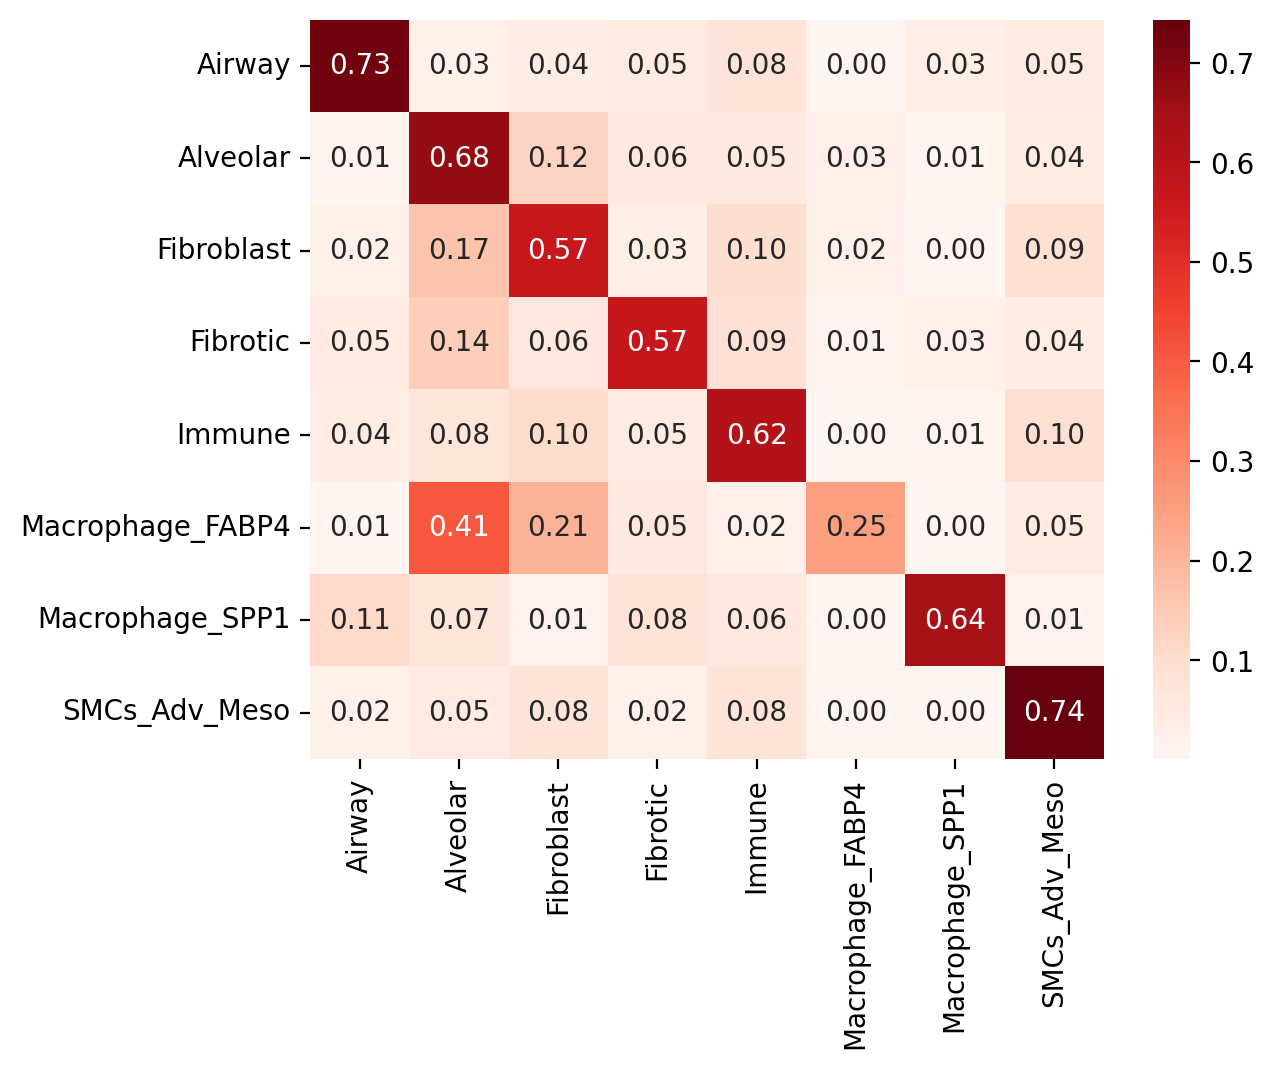

In [141]:
sns.heatmap(tab_IPF, annot=True, cmap=mymap, fmt=".2f" )
plt.savefig("./figures/PercentageOfInteractions_IPF_colorschanged.pdf")

# healthy

In [70]:
sq.gr.spatial_neighbors(healthy, spatial_key="spatial", library_key="sampleID",transform=None, n_rings=1)
sq.gr.nhood_enrichment(healthy, cluster_key="Niche_NMF",)

  0%|          | 0/1000 [00:00<?, ?/s]

In [71]:
#adata_vis.uns["leiden_nhood_enrichment"]["zscore"] = np.nan_to_num(adata_vis.uns["leiden_nhood_enrichment"]["zscore"], copy=True, nan=0.0, posinf=None, neginf=None)

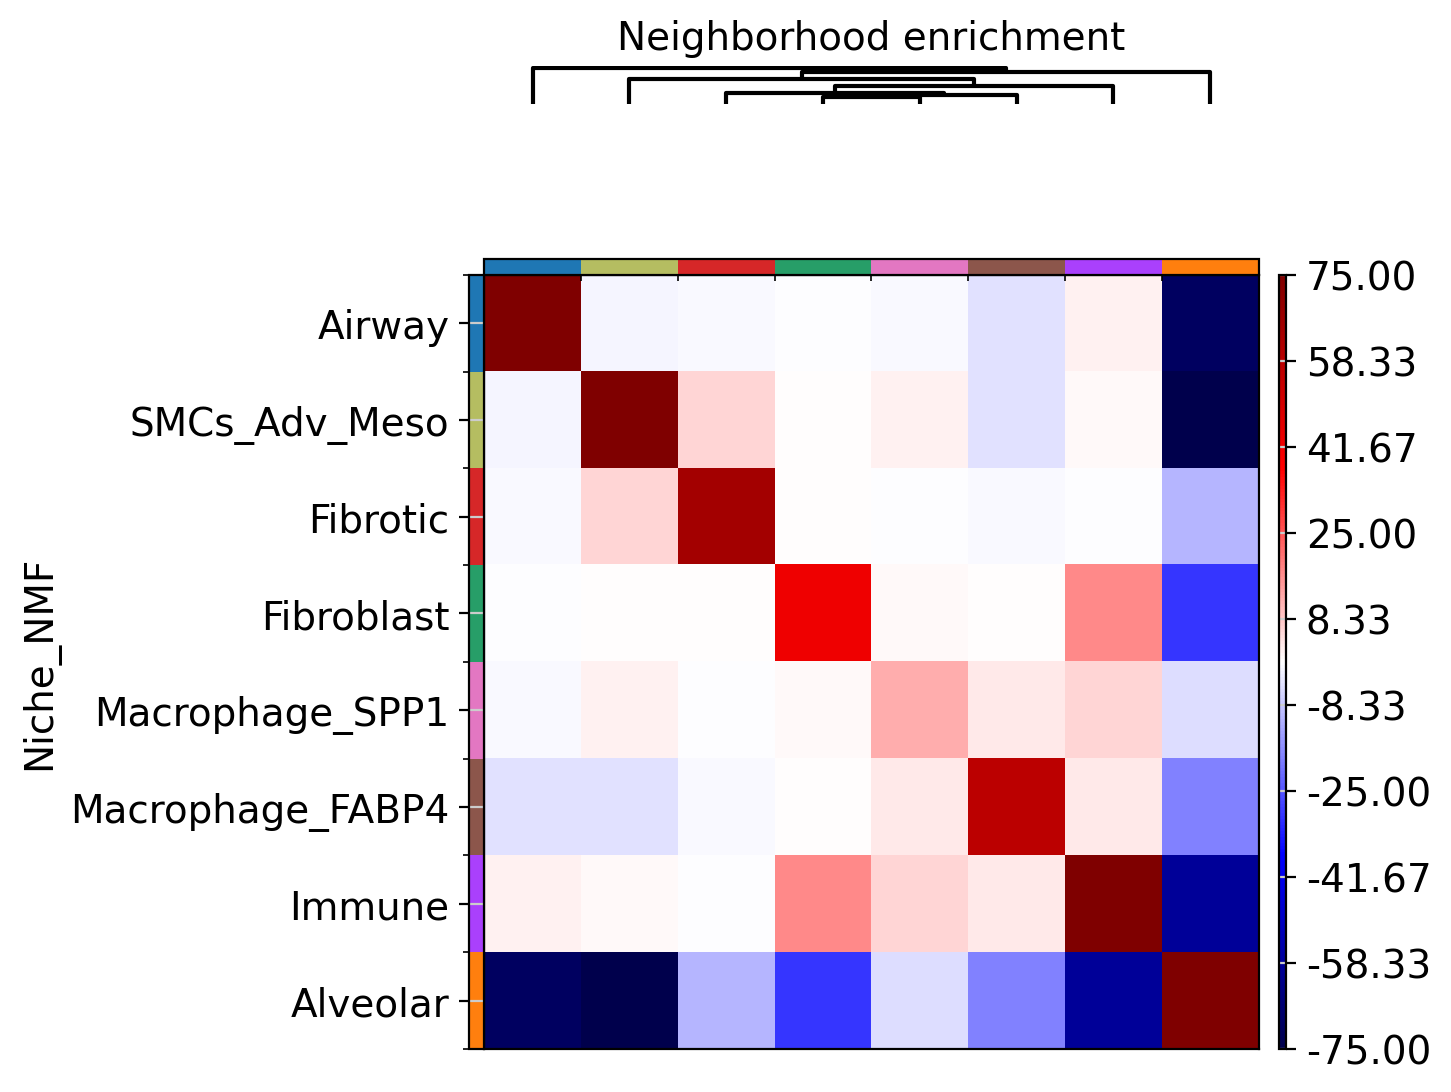

In [72]:
sq.pl.nhood_enrichment(healthy, cluster_key="Niche_NMF", method="average", cmap="seismic",vmin=-75, vmax=75, vcenter=0, figsize=(5,5),)# mode="zscore")

In [137]:
niche_healthy = pd.DataFrame(healthy.uns["Niche_NMF_nhood_enrichment"]["count"], index=healthy.obs['Niche_NMF'].cat.categories, columns = healthy.obs['Niche_NMF'].cat.categories)
niche_healthy

,Airway,Alveolar,Fibroblast,Fibrotic,Immune,Macrophage_FABP4,Macrophage_SPP1,SMCs_Adv_Meso
Airway,1342,309,17,0,34,0,0,69
Alveolar,309,133352,906,28,787,1419,23,3132
Fibroblast,17,906,250,1,99,20,1,79
Fibrotic,0,28,1,18,1,0,0,15
Immune,34,787,99,1,912,46,5,113
Macrophage_FABP4,0,1419,20,0,46,434,3,56
Macrophage_SPP1,0,23,1,0,5,3,2,5
SMCs_Adv_Meso,69,3132,79,15,113,56,5,4010


<Axes: >

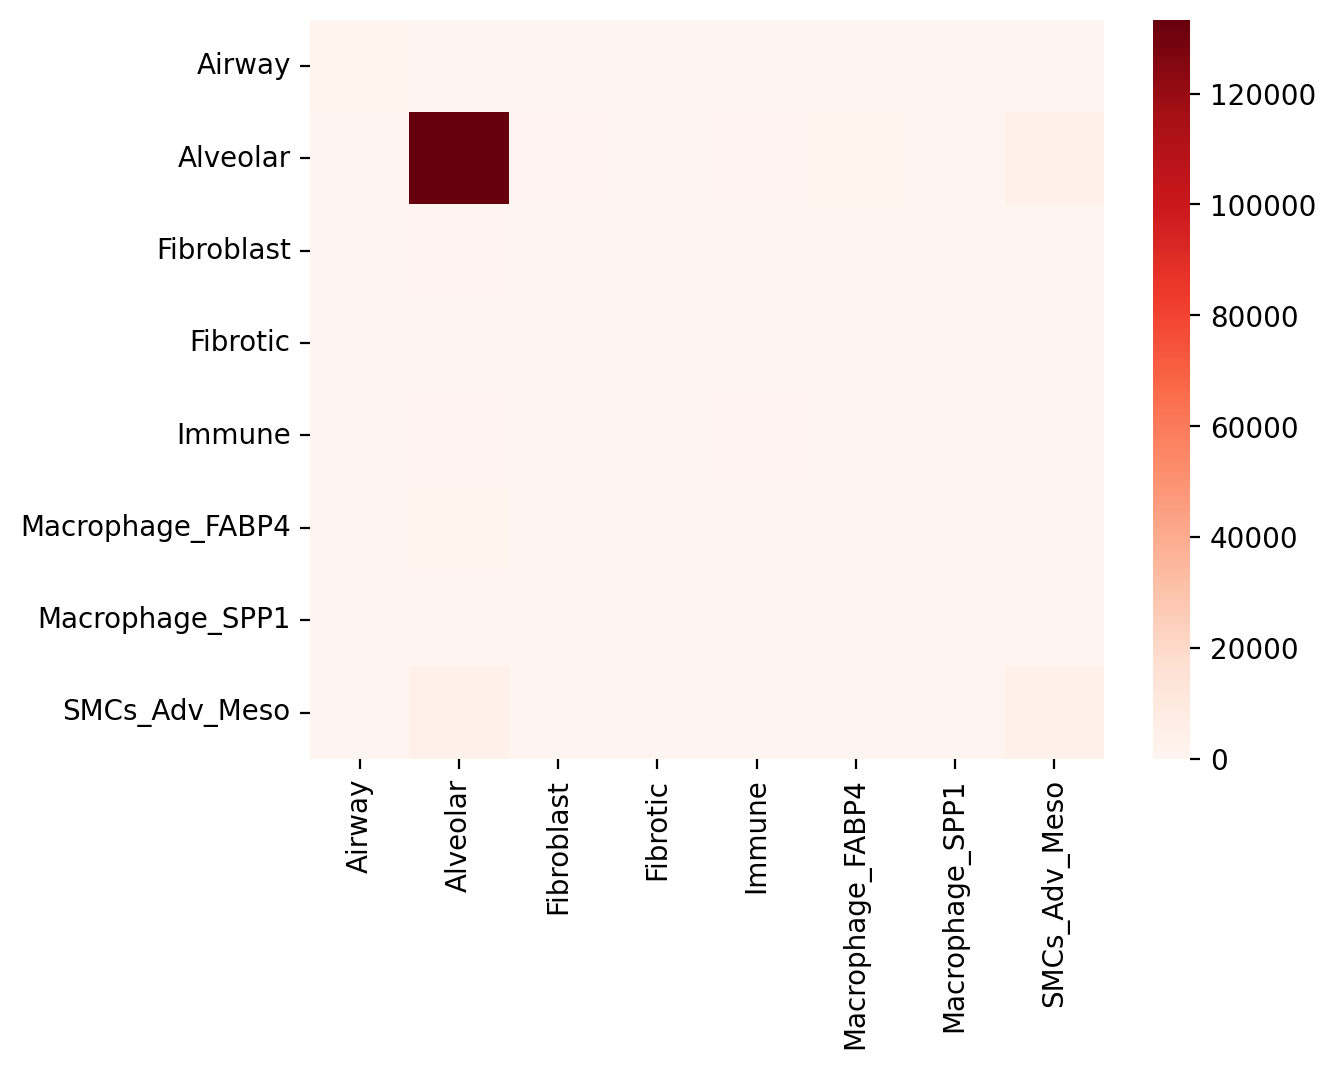

In [138]:
sns.heatmap(niche_healthy, annot=False, cmap=mymap, )

In [139]:
tab_healthy = niche_healthy.div(niche_healthy.sum(axis=1), axis=0)
tab_healthy

,Airway,Alveolar,Fibroblast,Fibrotic,Immune,Macrophage_FABP4,Macrophage_SPP1,SMCs_Adv_Meso
Airway,0.757764,0.174478,0.009599,0.000000,0.019198,0.000000,0.000000,0.038961
Alveolar,0.002208,0.952814,0.006473,0.000200,0.005623,0.010139,0.000164,0.022378
Fibroblast,0.012382,0.659869,0.182083,0.000728,0.072105,0.014567,0.000728,0.057538
Fibrotic,0.000000,0.444444,0.015873,0.285714,0.015873,0.000000,0.000000,0.238095
Immune,0.017026,0.394091,0.049574,0.000501,0.456685,0.023035,0.002504,0.056585
Macrophage_FABP4,0.000000,0.717391,0.010111,0.000000,0.023256,0.219414,0.001517,0.028311
Macrophage_SPP1,0.000000,0.589744,0.025641,0.000000,0.128205,0.076923,0.051282,0.128205
SMCs_Adv_Meso,0.009226,0.418773,0.010563,0.002006,0.015109,0.007488,0.000669,0.536168


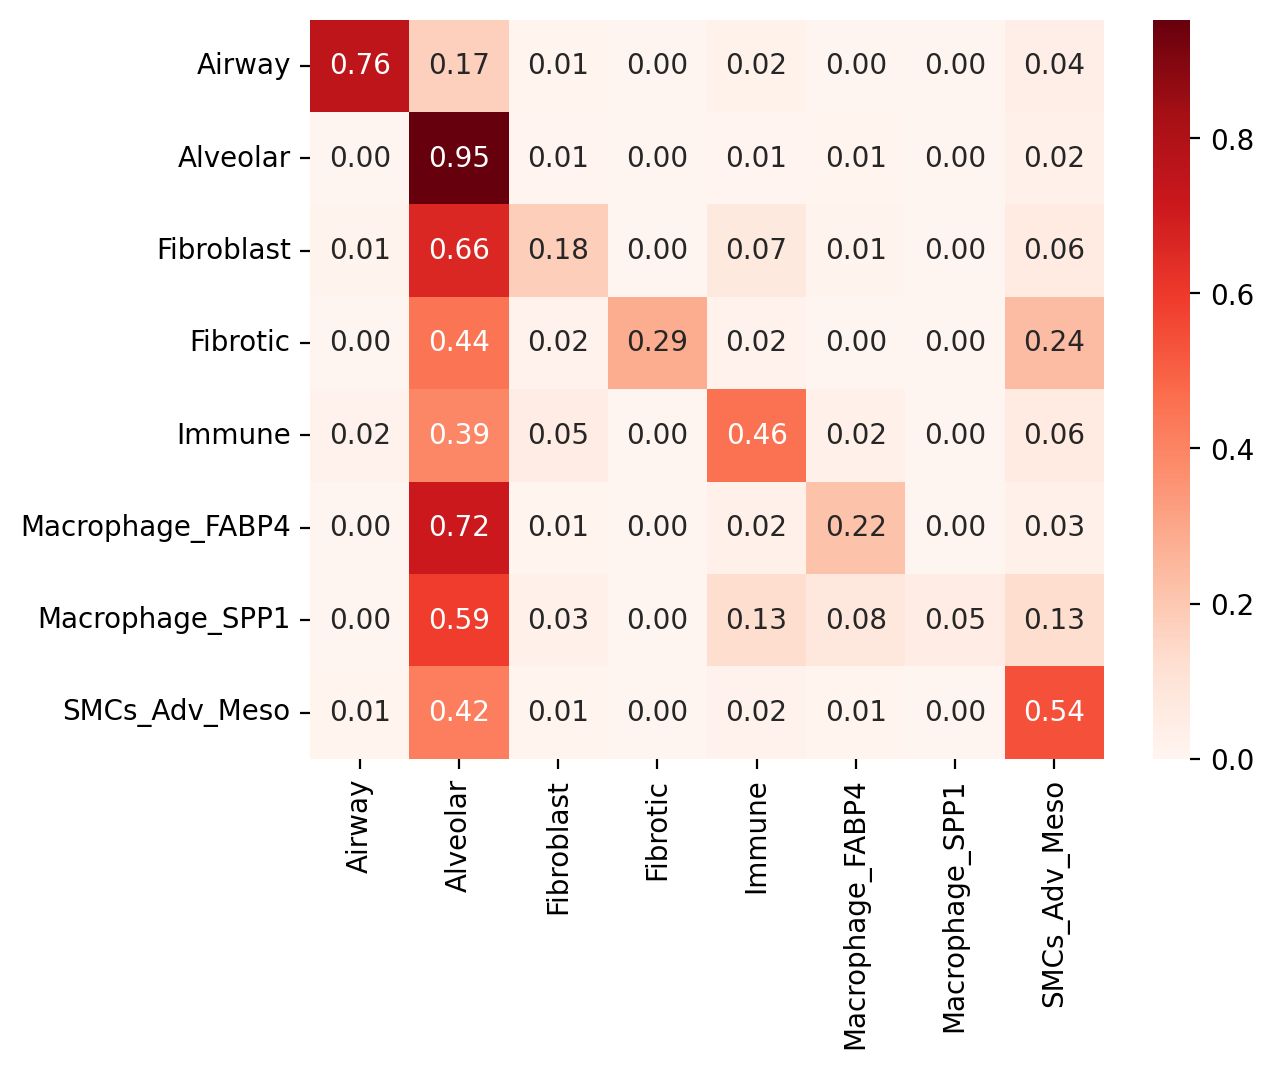

In [142]:
sns.heatmap(tab_healthy, annot=True, cmap=mymap, fmt=".2f")
plt.savefig("./figures/PercentageOfInteractions_Healthy_colorschanged.pdf")